In [1]:
#Importing builtin libraries
import os
import glob
import time
from itertools import product
from functools import partial
from concurrent.futures import ProcessPoolExecutor

In [2]:
#Number and data processing libraries
import pandas as pd
import numpy as np

In [3]:
#Image processing and visualization libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label

In [4]:
#scikit-learn libraries
import sklearn.model_selection as skmds
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [5]:
#video processing libraries
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

### Helper function for reading and normalizing the data

In [6]:
#script for reading vehicles, nonvehicles datasets
def _imreader(path):
    '''Image reader for reading
    image date from png to jpg format'''
    return mpimg.imread(path, format='jpg')


def normalizer(data_arr):
    """Normalize image or feature lists"""
    return (data_arr - data_arr.mean())/data_arr.std()


def read_vnv_data(base_path):
    """Function for preparing vehicles, non-vehicles datasets
       Input: Path for the data directory
       Output: numpy array for all image data along with vehicles
       non-vehicles labels.
    """
    # wild card type pattern matchin is used here to read file names
    vehicles_path = os.path.join(base_path, 'vehicles', '*', '*')
    non_vehicles_path = os.path.join(base_path, 'non-vehicles', '*', '*')

    vnv_data = {'vehicles': glob.glob(vehicles_path),
                'non_vehicles': glob.glob(non_vehicles_path)}

    # lambda function will not work with pool object
    # Use of pooling can make all the cpu cores work
    print("\nStart reading vehicle non-vehicle dataset...\n")
    with ProcessPoolExecutor() as pool:
        vehicles = np.array(list(pool.map(_imreader, vnv_data['vehicles'])))
        non_vehicles = np.array(list(pool.map(_imreader, vnv_data['non_vehicles'])))
        
    print()
    print(f"Number of vehicle images is {len(vehicles)}")
        
    print()
    print(f"Number of non-vehicle images is {len(non_vehicles)}")
        
    # making a single array vehicles followed by non-vehicles
    x_data_vnv = np.concatenate((vehicles, non_vehicles))
    # For vehicles setting the labels to 1
    # For non-vehicles setting the labels to 0
    y_data_vnv = np.concatenate((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))

    return x_data_vnv, y_data_vnv

In [7]:
# Read the vehicles non-vehicles datasets
xdata, ydata = read_vnv_data('data')
print()
print(f"Total number of samples available is {len(xdata)}")
print()
print(f"Shape of each image is {xdata.shape[1:]}")


Start reading vehicle non-vehicle dataset...


Number of vehicle images is 8792

Number of non-vehicle images is 8966

Total number of samples available is 17758

Shape of each image is (64, 64, 3)


In [8]:
# Resizing all 64x64 images to 32x32 dimension
xdata = np.array(list(map(lambda x: cv2.resize(x, (32, 32)), xdata)))
print(f'shape of each image is {xdata.shape[1:]}')

shape of each image is (32, 32, 3)


In [9]:
#Read all the test images
test_image_files = glob.glob('./test_images/*.jpg')
test_images = list(map(mpimg.imread, test_image_files))
print("\nNumber of test images is ", len(test_images))
print('\nShape of each image is ', test_images[0].shape)


Number of test images is  6

Shape of each image is  (720, 1280, 3)


In [10]:
# Helper function for showing single image
def imshow(image, cmap=None):
    if cmap is not None:
        plt.imshow(image, cmap)
    else:
        plt.imshow(image)
    plt.show()

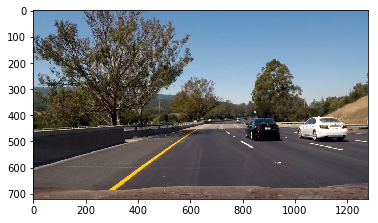

In [11]:
# plotting a test image
imshow(test_images[0])

In [12]:
#Helper function for showing 4*4 images
def plot_img(rows=4, cols=4, image_list=None, lab=None,
             random_indexing=True, dpi=100, sharey=False, wspace=0.8, hspace=0.6):
    '''Displaying 4x4 images
       in a single figure.
    '''
    assert image_list is not None, "There must be atleast one plotting image"
    assert rows*cols<=len(image_list), "No. of images must be greater than or equal to num_rows x num_columns"
    
    #Creating a subplot of 4x4 cells
    fig,axes = plt.subplots(nrows=rows, ncols=cols, sharey=sharey, squeeze=True)
    fig.set_dpi(dpi)
    #Adjusting the subplots axis gapings for better viewing
    fig.subplots_adjust(wspace=wspace,hspace=hspace)
    #creating a empty list to contain the image data
    #Generating 16 random numbers between 0 and the number of train data
    #for image indexing
    if (random_indexing) and (lab is not None):
        idx = np.random.randint(0,len(image_list),rows*cols)
        images = []
        labels = []
        for i in idx:
            images.append(image_list[i])
            labels.append(lab[i])
        for i,ax in enumerate(axes.flat):
            #Plot image
            ax.imshow(images[i])
            if labels[i] == 0:
                xlabel = 'non-vehicle'
            else:
                xlabel = 'vehicle'
                
            ax.set_xlabel(xlabel)
            ax.set_xticks([])
            ax.set_yticks([])
    else:
         for i,ax in enumerate(axes.flat):
            #Plot image
            ax.imshow(image_list[i])
    return fig

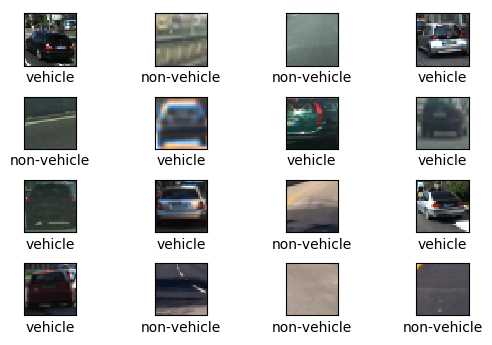

In [13]:
#Plotting some of randomly selected
#Vehicles non-vehicles images
plot_img(image_list=xdata, lab=ydata, random_indexing=True)
plt.show()

In [14]:
# Function for extracting spatial features from image
def bin_spatial(img, size=(32, 32)):
    """Function for extracting pixels features"""
    features = cv2.resize(img, size).ravel()
    return features

# Function for extraction color-histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Function for extracting histogram features of color space"""
    hist_feat = list(map(lambda x: np.histogram(img[:,:,x], bins=nbins, range=bins_range), [0, 1, 2]))
    
    return np.concatenate((hist_feat[0][0], hist_feat[1][0], hist_feat[2][0]))

## Function for extracting features from images for training

**We have to choose the hyperparameters too carefully because arbitrarily choosing these gives significant rise
of feature numbers which lead to the time consuming training and prediction operation. Accuracy is also greatly affected if wrongly choosed.**

In [15]:
def extract_features(image, color_space='YCrCb', spatial_feature=False, hist_feature= False,
                     hog_channel=0, orientations=8, cells_per_block=(5, 5), pixels_per_cell=(6, 6),
                     feature_vector=True, transform_sqrt=True, visualize=False, norm='L2-Hys',
                     spatial_size=(32, 32), nbins=32, bins_range=(0,256), normalize=True):
   
    """Here the color space used is YCrCb and we took hog features only from 
       Y space.  
    """
    spaces = ['RGB', 'HSV','LUB', 'HLS', 'YUV', 'YCrCb', 'GRAY']
    color_chnls = [0, 1, 2, 'ALL']
    features = []
    
    assert color_space in spaces, f"color space must be one of {', '.join(spaces)}"
    assert hog_channel in color_chnls, f"Color channel must be onr of {', '.join(color_chnls)}"
    
    hog_partial = partial(hog, orientations=orientations, pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block, block_norm=norm,
                          feature_vector=feature_vector, transform_sqrt=transform_sqrt,
                          visualise=visualize)
    
    if color_space != 'RGB':
        FLAG = eval(f'cv2.COLOR_RGB2{color_space}')
        feature_image = cv2.cvtColor(image, FLAG)
    else:
        feature_image = np.copy(image)
    
    if spatial_feature:
        spl_feat = bin_spatial(image, size=spatial_size)
        features.append(spl_feat)
        
    if hist_feature:
        hist_feat = color_hist(image, nbins=nbins, bins_range=bins_range)
        features.append(hist_feat)
        
    if color_space != 'GRAY':
        if hog_channel =='ALL':
            hog_feat = list(map(hog_partial, [feature_image[:,:,0],
                                              feature_image[:,:,1],
                                              feature_image[:,:,2]]))
            hog_feat = np.ravel(hog_feat)
        else:
            hog_feat = hog_partial(feature_image[:,:,hog_channel])
            
        features.append(hog_feat)
    else:
        features.append(hog_partial(feature_image))
        
        
    features = np.concatenate(features)

    if normalize:
        features = normalizer(features)
        
    return features

Total number of Hog features per image is  200


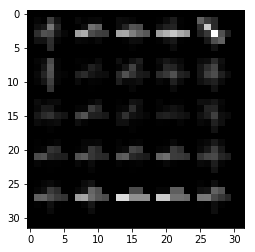

In [16]:
#visualizing a hog feature
vehicle_hog_feature, vehicle_hog_visual = extract_features(xdata[2], feature_vector=True,
                                                           visualize=True, normalize=False)
print('Total number of Hog features per image is ', vehicle_hog_feature.shape[0])
imshow(vehicle_hog_visual, cmap='gray')

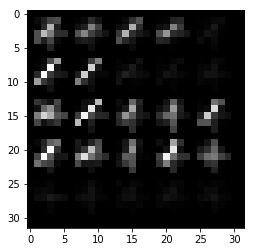

In [17]:
#visualizing a hog feature of a non vehicle image
non_vehicle_hog_feature, non_vehicle_hog_visual = extract_features(xdata[11000], feature_vector=True,
                                                                   visualize=True, normalize=False)
imshow(non_vehicle_hog_visual, cmap='gray')

In [18]:
# Extracting features from all images
# Here I use only the hog features on 'YCrCb' color space
# Taking hog features only on 'Y' space
with ProcessPoolExecutor() as pool:
    feat_map = pool.map(extract_features, xdata)
    features = np.array(list(feat_map), dtype=np.float64)
    
print('Extracted features for training and testing from  xdata set')

Extracted features for training and testing from  xdata set


In [19]:
#Now split the data into two parts with test_size ratio 0.2-1406
print('\nStrat splitting the data in training and testing parts with test size ratio 0.2')
X_train, X_test, y_train, y_test = skmds.train_test_split(features, ydata, test_size=0.2, random_state=42)

# shuffling the data to include more randomness and removing any biasness
print('\nShuffling the data to induce more randomness...')
X_train, y_train = shuffle(X_train, y_train)

# Now we train the data by Support Vector Classifier
# rbf kernel is used here
# LinearSVC() is more time efficient but gives more low accuracy
print('\nCreating a support vector classifier object...\n')
clf_vnv = SVC()
print(f'Start training over {len(X_train)} samples...')
t = time.time()
clf_vnv.fit(X_train, y_train)
print()
print(f'total time required for training {time.time() - t:.2f} seconds')
print('\nEvaluating scores on test data ....\n')
score = clf_vnv.score(X_test, y_test)
print(f'Accuracy score is {score:.4f}')


Strat splitting the data in training and testing parts with test size ratio 0.2

Shuffling the data to induce more randomness...

Creating a support vector classifier object...

Start training over 14206 samples...

total time required for training 15.66 seconds

Evaluating scores on test data ....

Accuracy score is 0.9809


In [20]:
def draw_rect(image, pts, color=(255, 0, 0), thickness=6):
    """Function for drawing rectangle on car object
        Input
       -------
       image: image array on which the rectangle is to be drawn.
       pts: list of CoOrdinates of a diagonal of rectangle
            in the form of (xmin, ymin, xmax, ymax)
       
       Output:
       -------
       Return the image with rectangles drawn on it. 
    """
    #number of rectangles to be drawn
    num_rect = len(pts)
    #iterate through all tuples in the list
    for i in range(num_rect):
        cv2.rectangle(image, tuple(pts[i][:2]), tuple(pts[i][-2:]), color, thickness)
    return image

In [21]:
def slide_window_search(image_arr,
                        window_size=128,
                        overlap_ratio=0.25,
                        cropping_yreg=(400, 670),
                        cropping_xreg=(750,1280)):
    """Sliding window search methods for single image"""
    # only serach through the lower half of the image array
    # y indices for cropping
    idy1, idy2 = cropping_yreg
    # x indices for cropping
    idx1, idx2 = cropping_xreg
    #now crop the image
    img_arr = image_arr[idy1:idy2, idx1:idx2,]
    # getting the height and width for the cropped image
    height, width = img_arr.shape[:2]
    # defining a empty list for appending the coordinates
    coords = []
    
    #setting the startx(idx1) and starty(idxy) to zero if
    #any of them has a none values.
    if idx1 is None:
        idx1 = 0
    if idy1 is None:
        idy1 = 0
        
    #Inner function for returning image window
    def _imfunc(z):
        # here input z is a tuple containing
        # starting window coordinates to be searched
        # defining nonlocal variables to be used from outer function
        nonlocal window_size, height, width, img_arr, coords
        
        #defining a condition in which range the windows caan take values
        CNDTN = (z[0] + window_size<=height) and (z[1] + window_size<=width)
        
        if CNDTN:
            #appending co-ordinates in original image coordinates
            coords.append((z[1]+idx1, z[0]+idy1,
                           z[1]+window_size+idx1, z[0]+window_size+idy1))
            #returning cropped image with specified window size
            return img_arr[z[0]:z[0]+window_size, z[1]:z[1]+window_size,]
        
    # pixel increment for on both horizontal or vertical direction
    incr = int(window_size * overlap_ratio)
    
    #now getting all the windows list which satisfy condition defined in _imfunc
    windows = list(map(_imfunc, product(range(0, height, incr), range(0, width, incr))))
    #removing all none values as windows contain none values where _imfunc does not
    #return any value
    windows = list(filter(lambda x: x is not None, windows))
    
    #as our classifier is trained on 64x64 images then resize it to 64x64
    if window_size != 32:
        windows = list(map(lambda x: cv2.resize(x, (32,32)), windows))
        
    #return the windows lists and corresponding co-ordinates
    return windows, coords

In [22]:
def variable_sliding_window_search(img_arr, parameters):
    
    '''Defining a variable window searching based on sliding window search.
       
       Objective for variable sliding window search:
       
       In many cases a single window search of a specified size may not 
       predict all the desired vehicles for that case sliding window search of
       different specified size, overlapping ratio, and X-Y region is necessary.
       Vehicles on a larger distance appeared to be smaller so a window size of
       32x32 or 48x48 is more efficient on detecting vehicles and vice-versa.
       
       Input:
       img_arr = Image array on which the sliding window search will operate.
       parameters = a list of tuple . first element of tuple is window size 
                    and second is overlapping ratio
       cropping_yreg = yregion to be searched
       cropping_xreg = xregion to be searched
       
       Output:
       returnnig theimage windows and lists of co-ordinates
       
       Caution: defining multiple windows and small overlap ratio produce
                many windows and extracting hog feature on these windows
                is time consuming.
       
    '''
    #assert len(params)==len(ypixel_range)==len(xpixel_range),\
    #"lengths of params, ypixel_range, xpixel_range must be equal"
    
    windows = []
    coords = []
    for param in parameters:
        for win_size, olap in zip(param['window_size'], param['overlap']):
            a, b = slide_window_search(img_arr,
                                       cropping_yreg=param['ypix_range'], 
                                       cropping_xreg=param['xpix_range'],
                                       window_size=win_size,
                                       overlap_ratio=olap)
            windows += a
            coords += b
            
    return windows, coords

In [23]:
def predict_coords(img_arr, parameters, visualize=True):
    '''Function for predicting coordinates and visualization
       Inputs:
        img_arr: Image array on which the we will predict
        visualize: Bool (True or False)
        
       Outputs: If visualize is true then returns predicted coordinates
                and rectangles drawn on the image. Else only returns the
                co-ordinates of the rectangles.
    '''
    
    windows, coords = variable_sliding_window_search(img_arr, parameters)
    
    img = np.copy(img_arr)
    
    
    features = np.array(list(map(extract_features, windows)))
    predictions = clf_vnv.predict(features)
    
    #get indices for vehicles
    vehicles = predictions.nonzero()[0]
    crds = list(map(lambda x:coords[x], vehicles))
    
    if visualize:
        rects = draw_rect(img, crds, (255, 0, 0), 5)
        return crds, rects
    
    return crds

In [24]:
#Functions for removing False Positives and multiple detections
def add_heat(heatmap, coordinates):
    # Iterate through list of bboxes
    for coord in coordinates:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[coord[1]:coord[3], coord[0]:coord[2]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap = np.copy(heatmap)
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [27]:
parameters = [{'ypix_range': (400, 670), 'xpix_range': (750, 1280), 'window_size': (128, ), 'overlap': (.25, )},
                {'ypix_range': (415, 463), 'xpix_range': (0, 500), 'window_size': (48,), 'overlap': (0.25,)},
                {'ypix_range': (400, 570), 'xpix_range': (750, 1280), 'window_size': (64, ), 'overlap': (.25,)}]

In [29]:
windows, _ = variable_sliding_window_search(test_images[0], parameters)
print('Number of windows to be searched', len(windows))

Number of windows to be searched 313


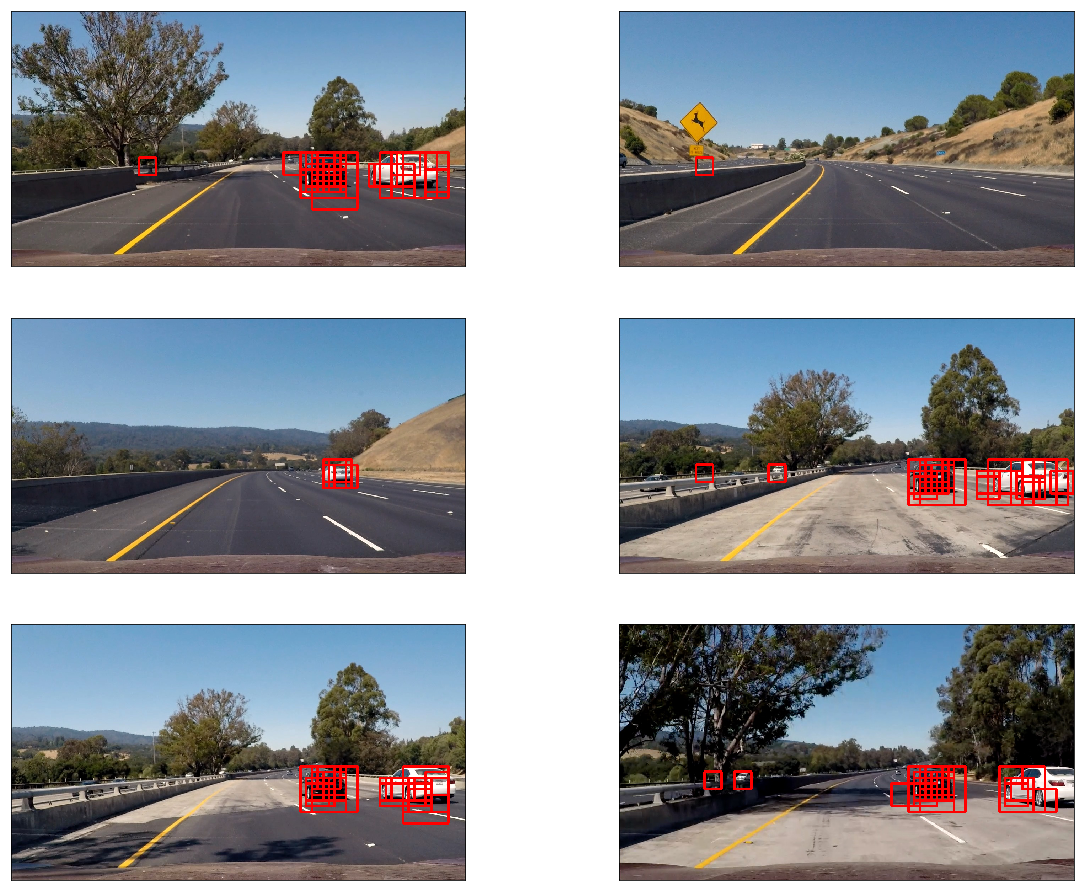

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()
for ax, img in zip(axes, test_images):
    _,rects = predict_coords(img, parameters)
    ax.imshow(rects)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

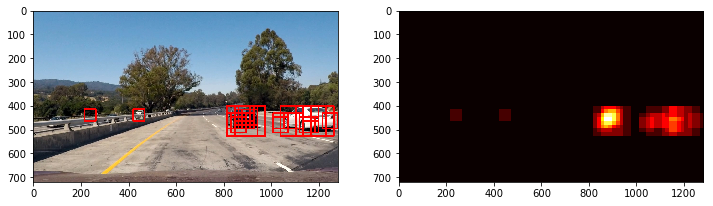

In [32]:
# Plotting 
coords, rects = predict_coords(test_images[3], parameters)
heat = np.zeros_like(test_images[3][:,:,0]).astype(np.float)
heat_map = add_heat(heat, coords)

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
ax1, ax2 = axes.flatten()
ax1.imshow(rects)
ax2.imshow(heat_map, cmap=plt.cm.hot)
plt.show()

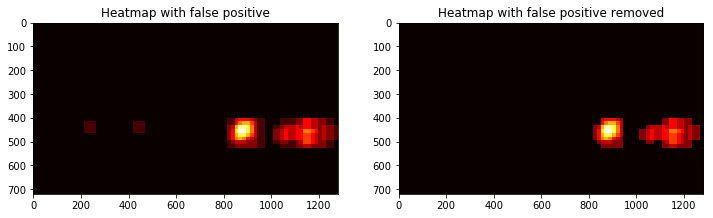

In [35]:
thresolded_heatmap = apply_threshold(heat_map, 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
ax1, ax2 = axes.flatten()
ax1.imshow(heat_map, cmap=plt.cm.hot)
ax1.set_title("Heatmap with false positive")
ax2.imshow(thresolded_heatmap, cmap=plt.cm.hot)
ax2.set_title("Heatmap with false positive removed")
plt.show()

Number of cars detected 2


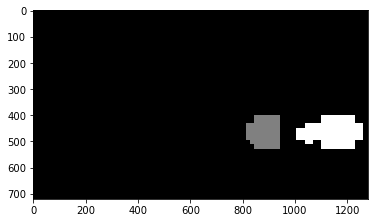

In [36]:
bbox, num_cars = label(thresolded_heatmap)
print('Number of cars detected', num_cars)
imshow(bbox, cmap='gray')

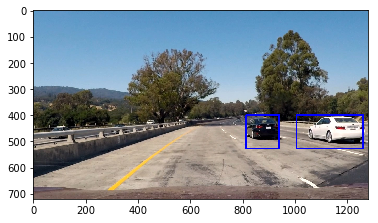

In [37]:
rects_on_img = draw_labeled_bboxes(test_images[3], label(thresolded_heatmap))
imshow(rects_on_img)

In [38]:
def imfunc(img_arr):
    """pipe line function for applying frame to frame in a video."""
    try:
        coords = predict_coords(img_arr, parameters, visualize=False)
        heat = np.zeros_like(img_arr[:,:,0]).astype(np.float)
        heat_map = add_heat(heat, coords)
        heat_map = apply_threshold(heat_map, 2)
        labels = label(heat_map)
        draw_labeled_bboxes(img_arr, labels)
        
    except Exception:
        pass
    return img_arr

In [39]:
names = os.listdir('test_images')

if not os.path.exists('test_outputs'):
    os.mkdir('test_outputs')
    
for image, name in zip(test_images, names):
    mpimg.imsave(os.path.join('test_outputs', name), imfunc(image), format='jpg')

In [34]:
# Working with video data
vclip = VideoFileClip('project_video.mp4')
#vclip.write_images_sequence("projImgSeq/frame%04d.jpeg")
#video_frames = sorted(glob.glob("projImgSeq/*.jpeg"))
transformed_clip = vclip.fl_image(imfunc)
transformed_clip.write_videofile('output.mp4')

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing audio in outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2706.04it/s]

[MoviePy] Done.
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [08:10<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

